In [1]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import random


In [2]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'
plt.rcParams['figure.figsize'] = (14.,5.)

In [3]:
ddir = '/swot/SUM03/tmp/CESM/'

In [4]:
client = Client('tcp://129.236.21.48:8089')
client

Client Scheduler: tcp://129.236.21.48:8089 Dashboard: http://129.236.21.48:8787/status,Cluster Workers: 16 Cores: 16 Memory: 8.66 TB


In [5]:
ds=xr.open_zarr(ddir+'hybrid_v5_rel04_BC5_ne120_t12_pop62', auto_chunk=False).chunk({'time': 3})
ds

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HT                  (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTE                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTN                 (nlat, nlon) float64 dask.

In [6]:
ds=ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

In [7]:
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HT                  (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTE                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTN                 (nlat, nlon) float64 dask.

In [18]:
def threeD_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

def extract_needed_variables(batch):
    shift_vars = ['SSH','XU','YU','TAUX','TAUY','SST']
    coord_vars = ['XU','YU']
    
    
    shifts = {'_e': dict(nlon=-1),
              '_w': dict(nlon=1),
             '_n': dict(nlat=-1),
             '_s': dict(nlat=1),
             '_ne': dict(nlon=-1,nlat=-1),
             '_nw': dict(nlon=1,nlat=-1),
             '_se': dict(nlon=-1,nlat=1),
             '_sw': dict(nlon=1,nlat=1),}
    
    
    for var in shift_vars:
        for suf, shift in shifts.items():
            batch[var + suf] = batch[var].shift(**shift)
            
    suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
    for suf in suffixes:
        batch['X'+suf],batch['Y'+suf],batch['Z'+suf], = threeD_coords(batch['XU'+suf],batch['YU'+suf])
    for var in coord_vars:
        for suf in suffixes:
            batch = batch.drop([var+suf])
    
    features = ['X', 'Y', 'Z','SSH','SST','TAUX','TAUY']
    batchb = batch.drop('time').isel(time=0)
    batchf = batch.drop('time').isel(time=1)
    batch0 = batch.drop('time').isel(time=2)     
    for vari in features:
        for suff in suffixes:
            batch0[vari+suff+'_f'] = batchf[vari+suff]
            batch0[vari+suff+'_b'] = batchb[vari+suff]
    return batch0
    
    #return batch
targets=['U','V']
coordfeatures = ['X','Y','Z']
features = ['SSH','SST','TAUX','TAUY']
sufx = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']

sufx2 = ['','_f','_b']
feature_cols = [feat+suf+suf2 for feat in features for suf in sufx for suf2 in sufx2]
feature_cols +=[cfeat+suf for cfeat in coordfeatures for suf in sufx]
#feature_cols = [feat+suf for feat in features for suf in sufx]


from sklearn.model_selection import train_test_split

def ds_to_df(batch, w_validation=False, choice='training'):
    #df = batch.reset_index('sample').to_dataframe()
    #X = df.dropna().reset_index(drop=True).loc[:, feature_cols]
    #y = df.dropna().reset_index(drop=True).loc[:, targets]
    #df = batch.drop('sample').to_dataframe().dropna().reset_index(drop=True)
    df = batch.to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    y = df.loc[:, targets]
    
    if w_validation:
        X,X_t,y,y_t = train_test_split(X,y,test_size=0.2)
        if (choice=='training'):
            return (X,y)
        elif (choice=='validation'):
            return (X_t,y_t)
    else:
        return (X,y)
    

In [19]:
randdate = random.sample(range(2, 10000), 9998)


In [22]:
%%time
for rd in randdate:
    print('Day %s'%rd)
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    #da = extract_needed_variables(ds.isel(time = slice(rd-3,rd+1,)).reset_coords()[vars_wanted])
    X,y = ds_to_df(extract_needed_variables(ds.isel(time=slice(rd-3,rd+1,)).reset_coords()[vars_wanted]))
    break

Day 5775
CPU times: user 52.7 s, sys: 46.2 s, total: 1min 38s
Wall time: 3min 51s


In [47]:
def mygen(**kwargs):
    for rd in randdate:
        da = extract_needed_variables(ds.isel(time=slice(rd-3,rd+1,)).reset_coords()[vars_wanted])
        yield ds_to_df(da,kwargs)

In [28]:
def my_generator(**kwargs):
    for rd in randdate:
        print('Day %s'%rd)
        vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
        yield ds_to_df(extract_needed_variables(ds.isel(time=slice(rd-3,rd+1,)).reset_coords()[vars_wanted]), kwargs)
        

In [34]:
from collections import OrderedDict


In [35]:
OrderedDict()

collections.OrderedDict

In [48]:
import tensorflow as tf
from tensorflow import keras

In [49]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(200, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(200, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(100, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(80, activation=tf.nn.relu, 
                       name='hidden_layer_4'),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_5'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse','accuracy'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 200)               27200     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 200)               40200     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 100)               20100     
_________________________________________________________________
hidden_layer_4 (Dense)       (None, 80)                8080      
_________________________________________________________________
hidden_layer_5 (Dense)       (None, 20)                1620      
_________________________________________________________________
output_layer (Dense)         (None, 2)                 42        
Total params: 97,242
Trainable params: 97,242
Non-trainable params: 0
_________________________________________________________________


In [50]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.mae = []
        self.val_mae = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.mae.append(logs.get('mean_absolute_error'))
        self.val_mae.append(logs.get('val_mean_absolute_error'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(18,5))
        plt.subplot(131)
        plt.plot(self.x, self.losses,alpha=0.5,color=color2,label="loss")
        plt.plot(self.x, self.val_losses,alpha=0.5,color=color1, label="val loss")
        plt.legend()
        plt.xlabel(r'Epoch');
        plt.ylabel('Mean Square Error');
        
        plt.subplot(132)
        plt.plot(self.x, self.mae,alpha=0.5,color=color2, label="training")
        plt.plot(self.x, self.val_mae,alpha=0.5,color=color1, label="validation")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel(r'Mean Abs Error [$cm/s$]');
        
        plt.subplot(133)
        plt.plot(self.x, self.accuracy,color=color2,alpha=0.5, label="training")
        plt.plot(self.x, self.val_accuracy,alpha=0.5,color=color1, label="validation")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Model Accuracy');
        plt.show();
        
plot_losses = PlotLosses()

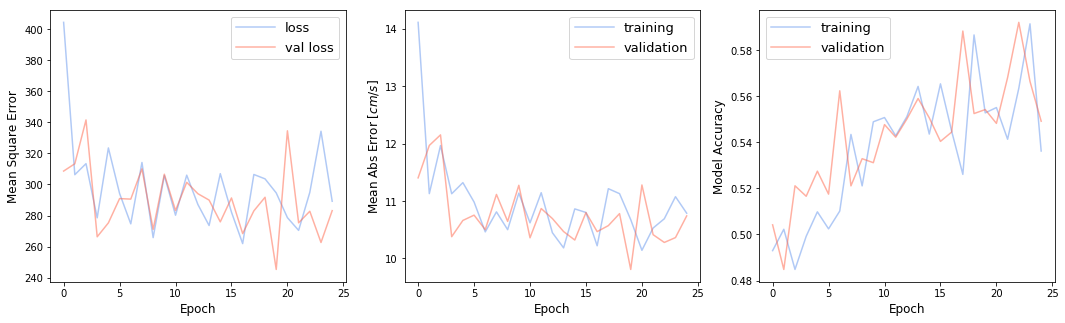

1/1 [==============================] - 557s 557s/step - loss: 289.2247 - mean_absolute_error: 10.7872 - mean_squared_error: 289.1853 - acc: 0.5362 - val_loss: 283.1698 - val_mean_absolute_error: 10.7401 - val_mean_squared_error: 283.1320 - val_acc: 0.5491
Epoch 26/750


In [ ]:
model_hist = model.fit_generator(generator=mygen(w_validation=True, choice='training'),
                                 validation_data=mygen(w_validation=True, choice='validation'),
                                 steps_per_epoch=1, validation_steps=1, epochs=750, callbacks=[plot_losses])
#, use_multiprocessing=True, workers=10)


In [17]:
coordfeatures = ['X','Y','Z']
features = ['SSH','SST','TAUX','TAUY']
sufx = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']

sufx2 = ['','_f','_b']
feature_cols = [feat+suf+suf2 for feat in features for suf in sufx for suf2 in sufx2]
feature_cols +=[cfeat+suf for cfeat in coordfeatures for suf in sufx]
len(feature_cols)

135

In [15]:
len(X.columns)

189

In [16]:
dab = da.drop('time').isel(time=0)
da0 = da.drop('time').isel(time=1)
daf = da.drop('time').isel(time=2)


In [20]:
variables = ['SST','SSH','TAUX','TAUY']
suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
for var in variables:
    for suf in suffixes:
        da0[var+suf+'_f'] = daf[var+suf]        
        da0[var+suf+'_b'] = dab[var+suf]

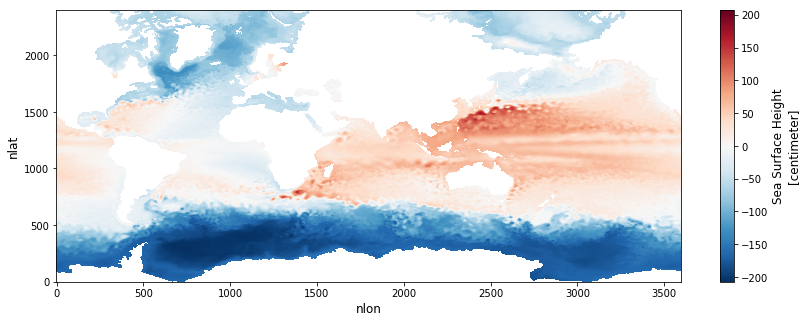

In [22]:
da0.SSH_nw_f.plot()